In [2]:
import os
import gc
import optuna
import warnings
import numpy as np
from utils import *
import pandas as pd
from copy import deepcopy
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%run skills.ipynb
%run languages.ipynb
%run work_experiences.ipynb
%run education.ipynb

class config:
    train_path = '../../../datasets/garanti-bbva-data-camp/train_users.csv'
    test_path = '../../../datasets/garanti-bbva-data-camp/test_users.csv'
    sub_path = '../../../datasets/garanti-bbva-data-camp/submission.csv'
    skills_path = '../../../datasets/garanti-bbva-data-camp/skills.csv'
    languages_path = '../../../datasets/garanti-bbva-data-camp/languages.csv'
    education_path = '../../../datasets/garanti-bbva-data-camp/education.csv'
    exp_path = '../../../datasets/garanti-bbva-data-camp/work_experiences.csv'
    seed = 42
    n_folds = 6

In [3]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)
sub = pd.read_csv(config.sub_path)

print(f'train_df shape: {train_df.shape}')
print(f'test_df shape: {test_df.shape}')
df = train_df.append(test_df).reset_index(drop = True)
df.head()

train_df shape: (53019, 4)
test_df shape: (13255, 3)


,user_id,industry,location,moved_after_2019
0,1301,Information Technology and Services,"Istanbul, Istanbul, Turkey",1.0
1,6950,Internet,"Istanbul, Istanbul, Turkey",0.0
2,4880,Online Media,Turkey,0.0
3,26046,Telecommunications,"Istanbul, Istanbul, Turkey",0.0
4,11005,Banking,"Istanbul, Turkey",0.0


In [4]:
def fix_location(dataframe: pd.DataFrame, feature: str = 'location') -> pd.DataFrame:

    df_ = dataframe.copy()
    df_.loc[df_[feature].astype(str).str.contains('Kahraman Maras'), feature] = 'Kahramanmaras, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Şanliurfa'), feature] = 'Sanliurfa, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('İçel'), feature] = 'Mersin, Turkey'
    df_.loc[df_[feature].astype(str).str.contains('Afyon'), feature] = 'Afyonkarahisar, Turkey'
    df_[feature] = df_[feature].apply(lambda x: str(x).replace('Türkiye', 'Turkey'))
    df_[feature] = df_[feature].apply(lambda x: x.upper().strip())
    df_[feature] = df_[feature].apply(lambda x: translation(str(x)))
    tr_cities = load_tr_cities()
    for city in tr_cities:
        df_[feature] = df_[feature].apply(lambda x: city if city in x else x)
        df_[f'{feature}_based_on_tr'] = df_[feature].apply(lambda x: 1 if x in tr_cities or x == 'TURKEY' else 0)

    return df_

df = fix_location(df)

In [5]:
skills_df = load_skills(config.skills_path, 120)
lang_df = load_languages(config.languages_path, 20)
edu_df = load_education(config.education_path, 70, 70)
exp_df = load_work_experiences(config.exp_path)

df = df.merge(skills_df, on = ['user_id'], how = 'left')
df = df.merge(lang_df, on = ['user_id'], how = 'left')
df = df.merge(edu_df, on = ['user_id'], how = 'left')
df = df.merge(exp_df, on = ['user_id'], how = 'left')

df['nunique_company_by_industries'] = df.groupby(by = 'industry')['company_id'].transform('nunique')
#df['nunique_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')
#df['nunique_locations_by_industries'] = df.groupby(by = 'industry')['location'].transform('nunique')

#df['employee_total_last_exp_diff'] = df['employee_total_experience'] - df['employee_last_experience']

#df['nunique_employees_by_industries'] = df.groupby(by = 'industry')['user_id'].transform('nunique')

print(df.shape)
df.head()

Frequency of top 20 skills before preprocess: 294433
Frequency of top 20 skills after preprocess: 325856
(66274, 299)


,user_id,industry,location,moved_after_2019,location_based_on_tr,skill_agile,skill_agile methodologies,skill_ajax,skill_analizi,skill_analysis,...,employee_last_experience_year,nunique_company,employee_avg_days_to_quit,employee_last_quit,company_id,company_avg_days_to_quit,company_std_days_to_quit,company_max_days_to_quit,company_med_days_to_quit,nunique_company_by_industries
0,1301,Information Technology and Services,ISTANBUL,1.0,1,1.0,1.0,0.0,0.0,0.0,...,2018.0,3.0,447.000000,882.0,26.0,912.280537,808.719538,5206.0,701.0,3260.0
1,6950,Internet,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,2017.0,4.0,525.250000,184.0,1337.0,393.769231,376.905194,1155.0,184.0,743.0
2,4880,Online Media,TURKEY,0.0,1,0.0,0.0,1.0,0.0,0.0,...,2017.0,4.0,456.500000,273.0,4366.0,NaN,NaN,NaN,NaN,32.0
3,26046,Telecommunications,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,1.0,...,2014.0,1.0,3409.000000,NaN,26.0,912.280537,808.719538,5206.0,701.0,660.0
4,11005,Banking,ISTANBUL,0.0,1,0.0,0.0,0.0,0.0,0.0,...,2017.0,3.0,1136.333333,2435.0,1562.0,837.166667,767.031502,3957.0,609.0,424.0


In [6]:
#from kmodes.kmodes import KModes
#
#cluster = KModes(n_clusters=6, n_jobs=-1)
#
#df['kmodes_label'] = cluster.fit_predict(df[[col for col in df.columns if 
#                        col.startswith('skill') or
#                        col.startswith('degree') or
#                        col.startswith('study') or
#                        col.startswith('language')]].fillna(0))



In [7]:
target = 'moved_after_2019'
cat_features = ['industry', 'location', 'company_id', 'employee_last_experience_year', 'employee_last_experience_month']
drop_features = ['user_id']

for caterogical_col in cat_features:
    df[caterogical_col] = df[caterogical_col].astype(str).astype("category")

train_set = df.loc[df[target].notnull()].drop(columns=drop_features, axis = 1)
test_set = df.loc[df[target].isnull()].drop(columns=drop_features, axis = 1)

print(f'train_set: {train_set.shape}')
print(f'test_set: {test_set.shape}')

train_set: (53019, 298)
test_set: (13255, 298)


In [8]:
# CatBoost Parameters
#params = {'one_hot_max_size': 179,
#          'depth': 12,
#          'boosting_type': 'Plain',
#          'bootstrap_type': 'MVS',
#          #'bagging_temperature': 0.2
#          }

params = {'one_hot_max_size': 180,
          'depth': 12,
          #'learning_rate': 0.02,
          'boosting_type': 'Plain',
          'bootstrap_type': 'MVS'}

params["iterations"] = 4000
params['random_state'] = config.seed
params['cat_features'] = cat_features
params['eval_metric'] = 'Accuracy'
params['allow_writing_files'] = False
params['verbose'] = False

## XGB Parameters
#params = {'max_depth': 10,
#          'subsample': 0.8,
#          'eta': 0.02,
#          'reg_alpha': 2,
#          'reg_lambda': 24,
#          'learning_rate': 0.01}
#
##params['eval_metric'] = 'Accuracy'
#params['random_state'] = config.seed
#params['tree_method'] = 'hist'
#params['n_estimators'] = 5000
#params['enable_categorical'] = True

kf = KFold(n_splits=config.n_folds, shuffle=True, random_state=config.seed)
#kf = KFold(n_splits=config.n_folds)

In [9]:
X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])
y_score = np.zeros((X_test.shape[0], 2))

scores = list()
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = CatBoostClassifier(**params)
    #model = XGBClassifier(**params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=400,
        verbose=200,
    )

    #plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    test_score = model.predict_proba(X_test)
    y_score += test_score / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    scores.append(accuracy_score(y_val, val_pred))
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')
print(f'folds avg accuracy: {np.mean(scores)}')
cat_scores = deepcopy(y_score)

-----------------------------------| Fold 1 |-----------------------------------
Learning rate set to 0.044197
0:	learn: 0.6591372	test: 0.6342650	best: 0.6342650 (0)	total: 362ms	remaining: 24m 6s
200:	learn: 0.8402517	test: 0.7462940	best: 0.7462940 (200)	total: 42.4s	remaining: 13m 21s
400:	learn: 0.9030148	test: 0.7621365	best: 0.7623628 (393)	total: 1m 24s	remaining: 12m 41s
600:	learn: 0.9411978	test: 0.7691524	best: 0.7691524 (600)	total: 2m 8s	remaining: 12m 6s
800:	learn: 0.9611154	test: 0.7731130	best: 0.7734525 (798)	total: 2m 51s	remaining: 11m 23s
1000:	learn: 0.9724548	test: 0.7759421	best: 0.7761684 (914)	total: 3m 33s	remaining: 10m 40s
1200:	learn: 0.9805803	test: 0.7786579	best: 0.7789974 (1192)	total: 4m 16s	remaining: 9m 57s
1400:	learn: 0.9859219	test: 0.7788842	best: 0.7792237 (1383)	total: 4m 59s	remaining: 9m 15s
1600:	learn: 0.9890679	test: 0.7787711	best: 0.7799027 (1448)	total: 5m 41s	remaining: 8m 31s
1800:	learn: 0.9914218	test: 0.7796764	best: 0.7808080 (1

accuracy: 0.7817008996774741

-----------------------------------| Fold 1 |-----------------------------------
[0]	validation_0-logloss:0.68989
[200]	validation_0-logloss:0.54164
[400]	validation_0-logloss:0.51038
[600]	validation_0-logloss:0.49133
[800]	validation_0-logloss:0.47688
[1000]	validation_0-logloss:0.46631
[1200]	validation_0-logloss:0.45935
[1400]	validation_0-logloss:0.45522
[1600]	validation_0-logloss:0.45314
[1800]	validation_0-logloss:0.45231
[2000]	validation_0-logloss:0.45269
[2200]	validation_0-logloss:0.45394
[2243]	validation_0-logloss:0.45444


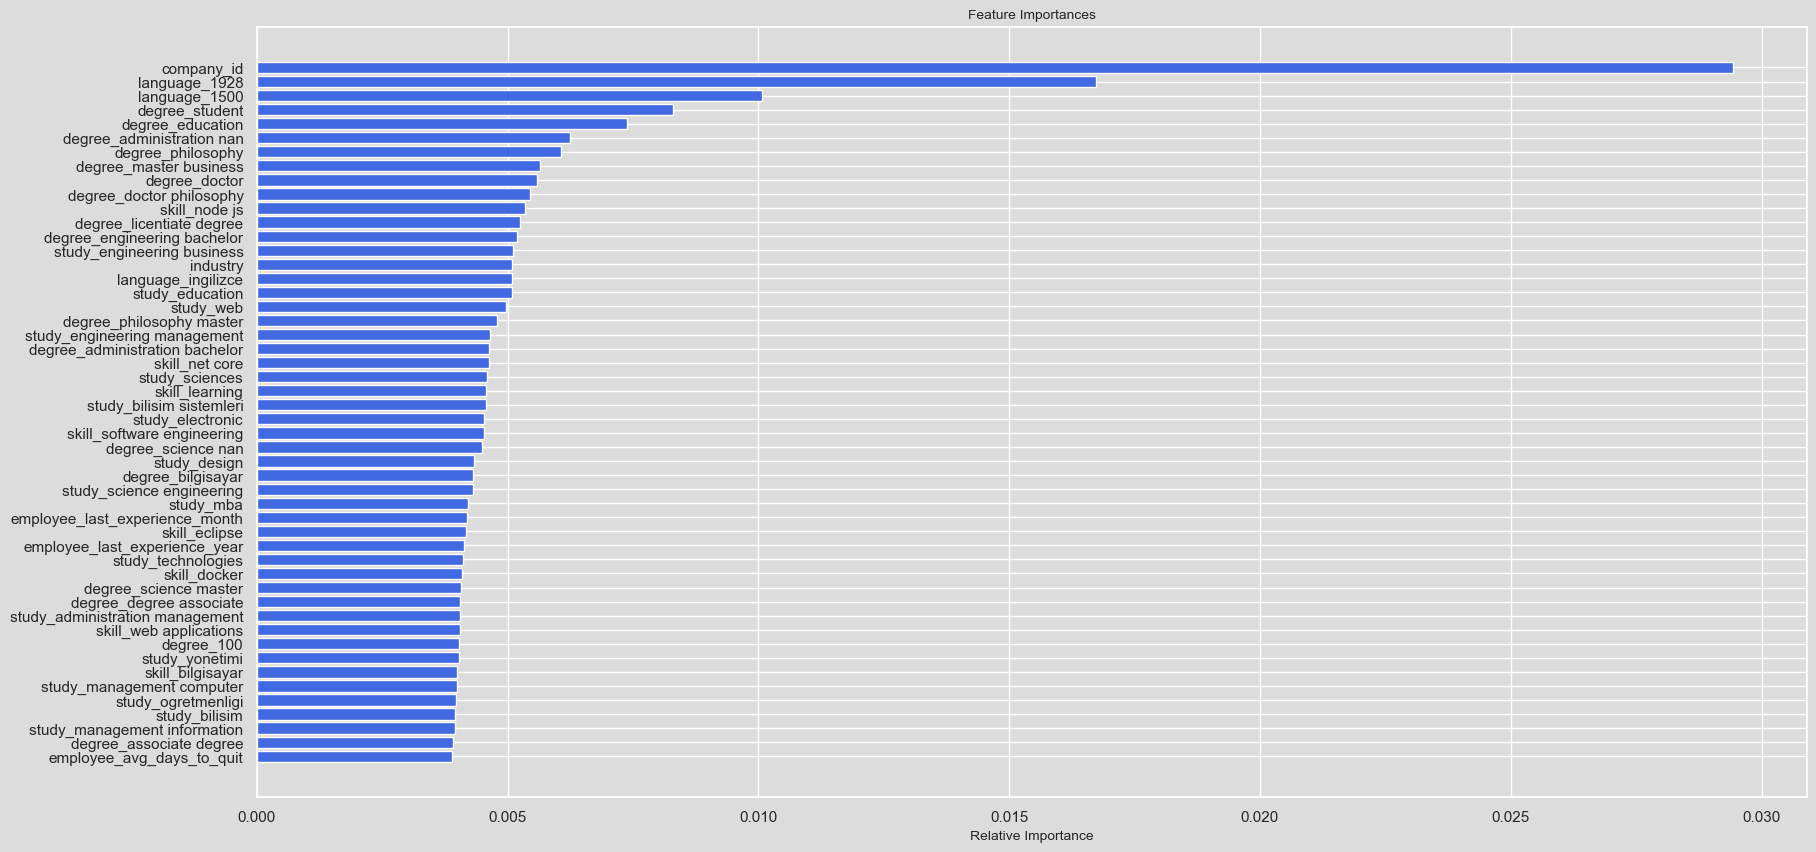

fold accuracy: 0.7814869299536041
-----------------------------------| Fold 2 |-----------------------------------
[0]	validation_0-logloss:0.68930
[200]	validation_0-logloss:0.52320
[400]	validation_0-logloss:0.49005
[600]	validation_0-logloss:0.46954
[800]	validation_0-logloss:0.45440
[1000]	validation_0-logloss:0.44372
[1200]	validation_0-logloss:0.43675
[1400]	validation_0-logloss:0.43276
[1600]	validation_0-logloss:0.42998
[1800]	validation_0-logloss:0.42911
[2000]	validation_0-logloss:0.42946
[2200]	validation_0-logloss:0.43075
[2229]	validation_0-logloss:0.43107


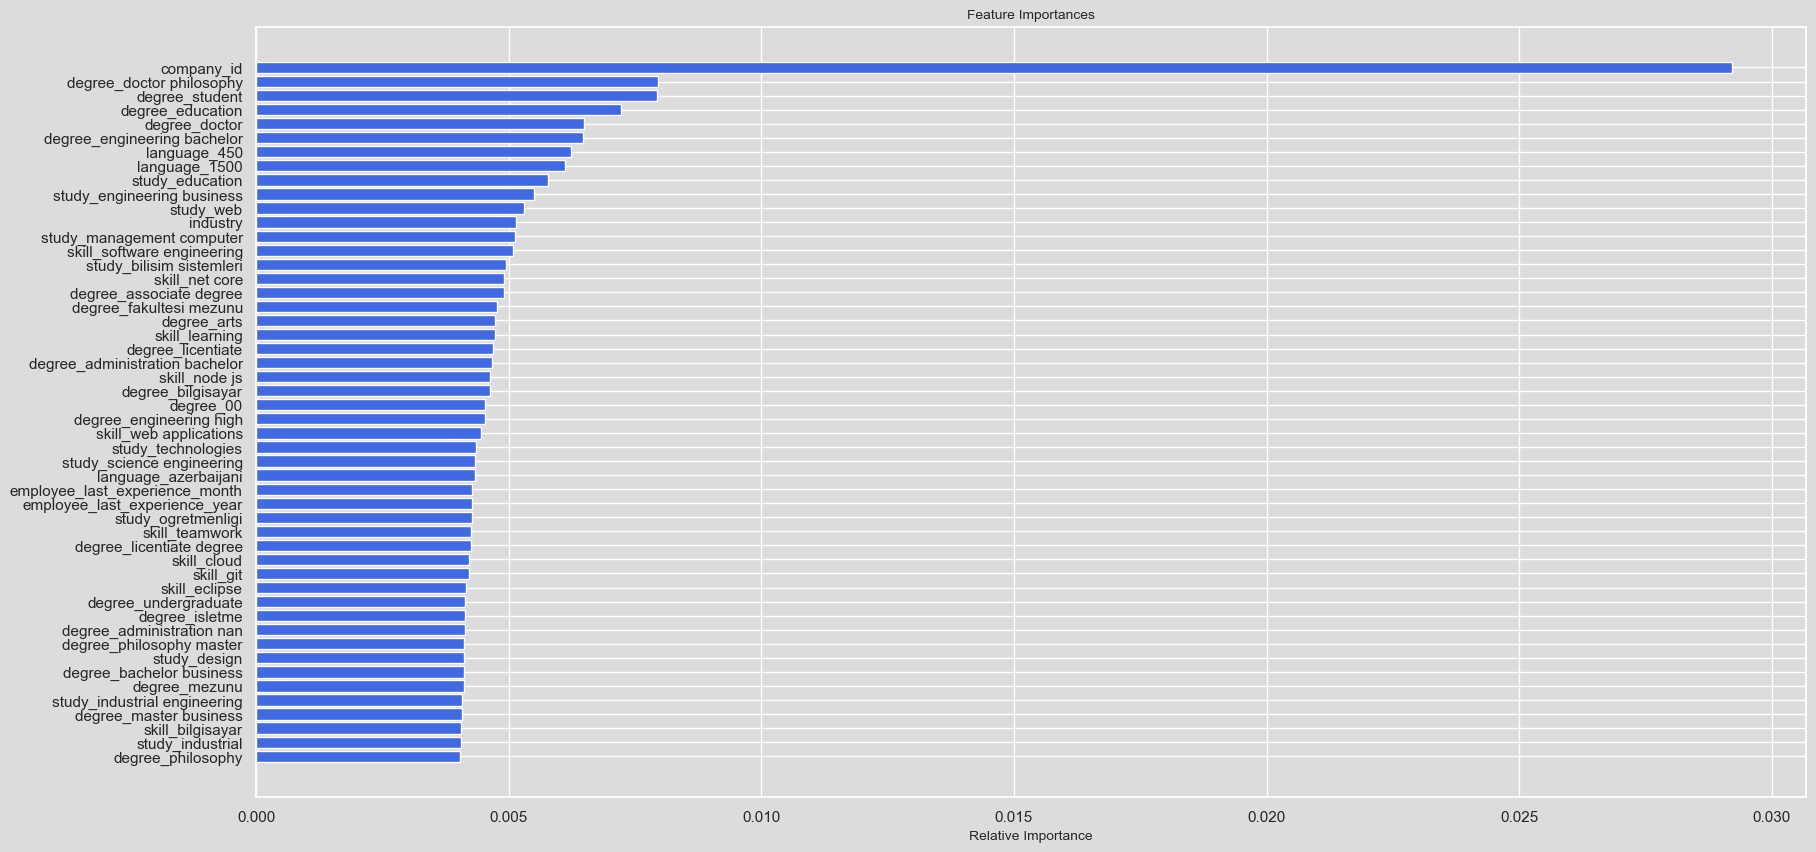

fold accuracy: 0.7926898268643204
-----------------------------------| Fold 3 |-----------------------------------
[0]	validation_0-logloss:0.68965
[200]	validation_0-logloss:0.53507
[400]	validation_0-logloss:0.50488
[600]	validation_0-logloss:0.48485
[800]	validation_0-logloss:0.47108
[1000]	validation_0-logloss:0.46057
[1200]	validation_0-logloss:0.45372
[1400]	validation_0-logloss:0.44961
[1600]	validation_0-logloss:0.44782
[1800]	validation_0-logloss:0.44673
[2000]	validation_0-logloss:0.44722
[2193]	validation_0-logloss:0.44893


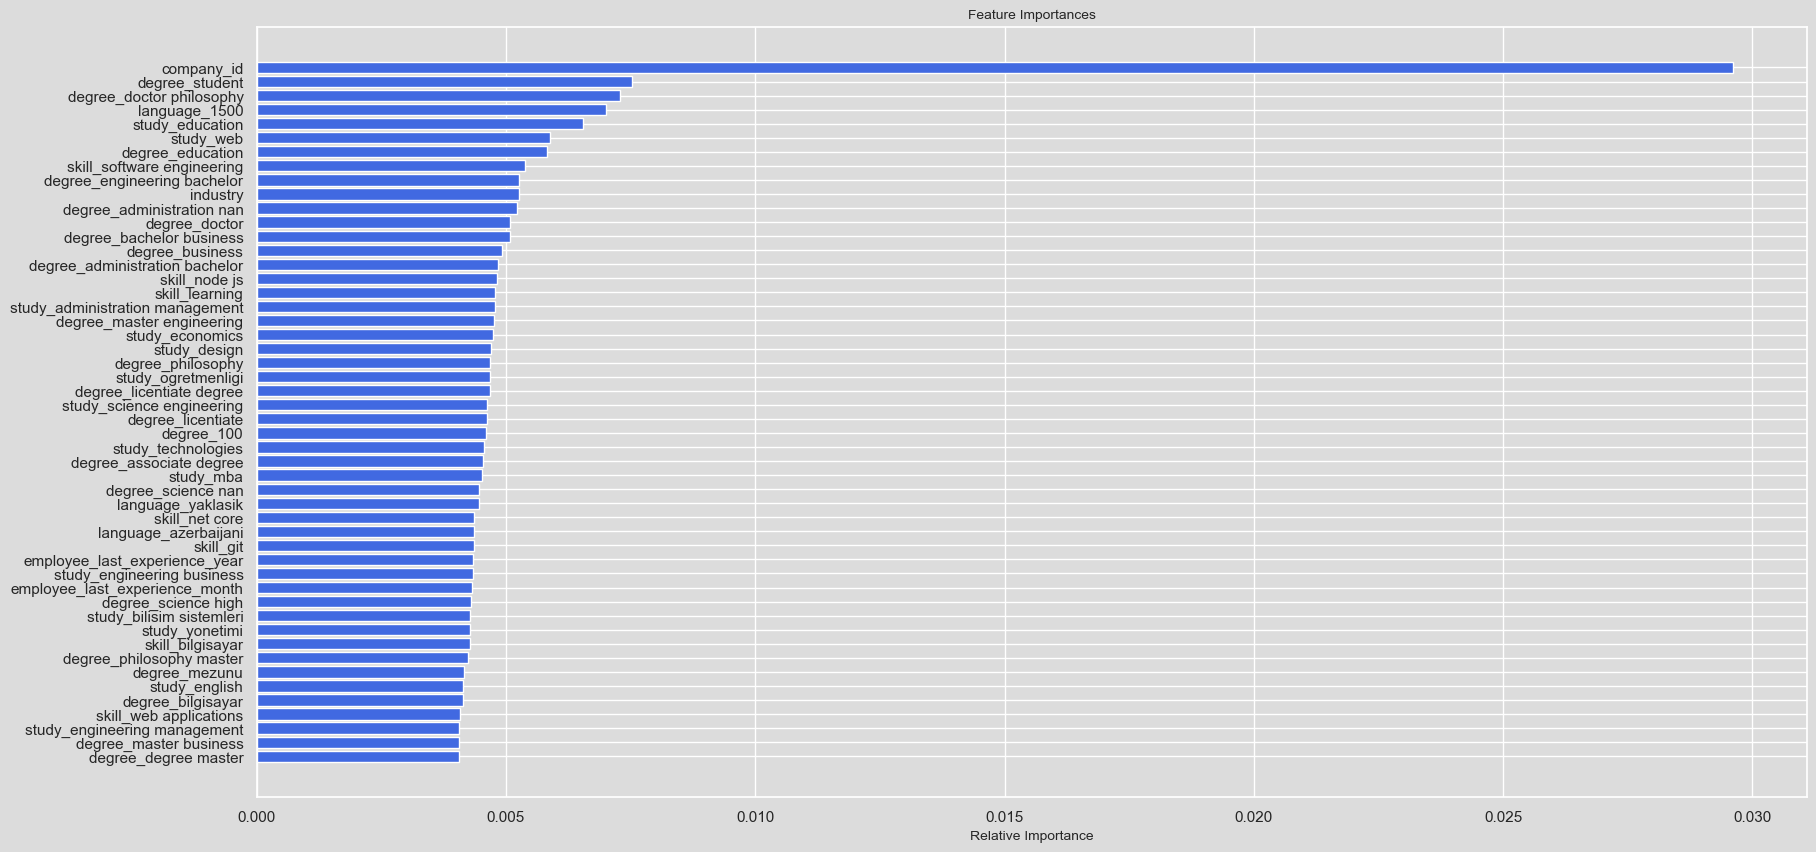

fold accuracy: 0.7857870317981215
-----------------------------------| Fold 4 |-----------------------------------
[0]	validation_0-logloss:0.68975
[200]	validation_0-logloss:0.53597
[400]	validation_0-logloss:0.50671
[600]	validation_0-logloss:0.48690
[800]	validation_0-logloss:0.47262
[1000]	validation_0-logloss:0.46159
[1200]	validation_0-logloss:0.45368
[1400]	validation_0-logloss:0.44864
[1600]	validation_0-logloss:0.44584
[1800]	validation_0-logloss:0.44500
[2000]	validation_0-logloss:0.44434
[2200]	validation_0-logloss:0.44487
[2352]	validation_0-logloss:0.44574


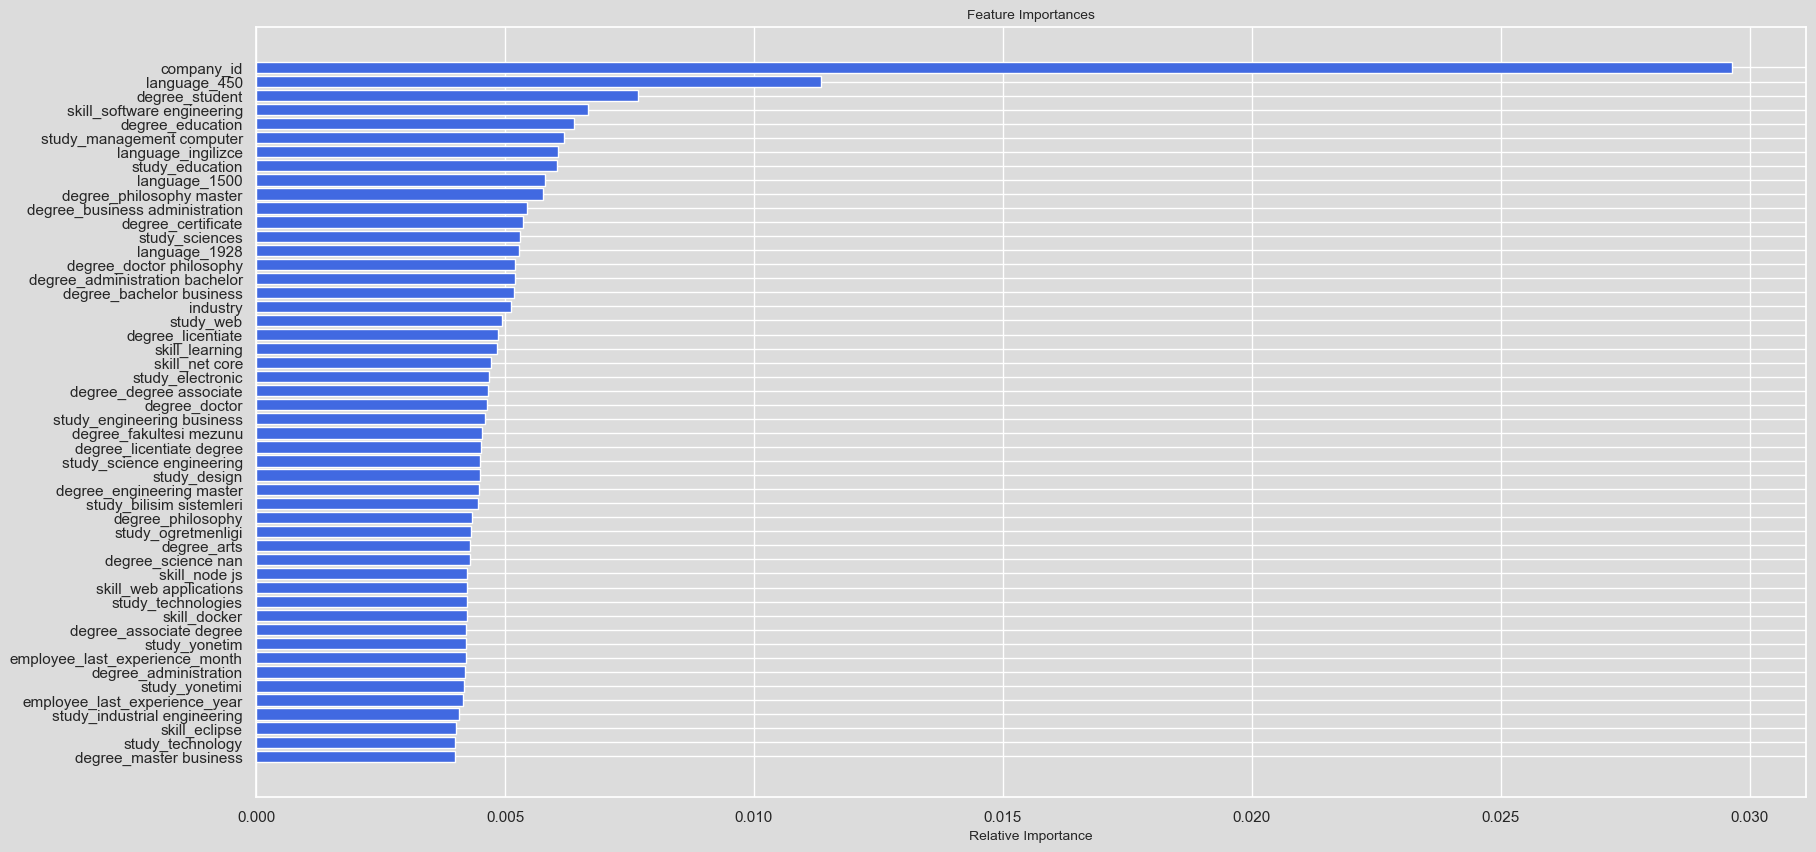

fold accuracy: 0.7837256677229516
-----------------------------------| Fold 5 |-----------------------------------
[0]	validation_0-logloss:0.68959
[200]	validation_0-logloss:0.53527
[400]	validation_0-logloss:0.50505
[600]	validation_0-logloss:0.48621
[800]	validation_0-logloss:0.47323
[1000]	validation_0-logloss:0.46376
[1200]	validation_0-logloss:0.45734
[1400]	validation_0-logloss:0.45306
[1600]	validation_0-logloss:0.45098
[1800]	validation_0-logloss:0.45109
[2000]	validation_0-logloss:0.45164
[2082]	validation_0-logloss:0.45228


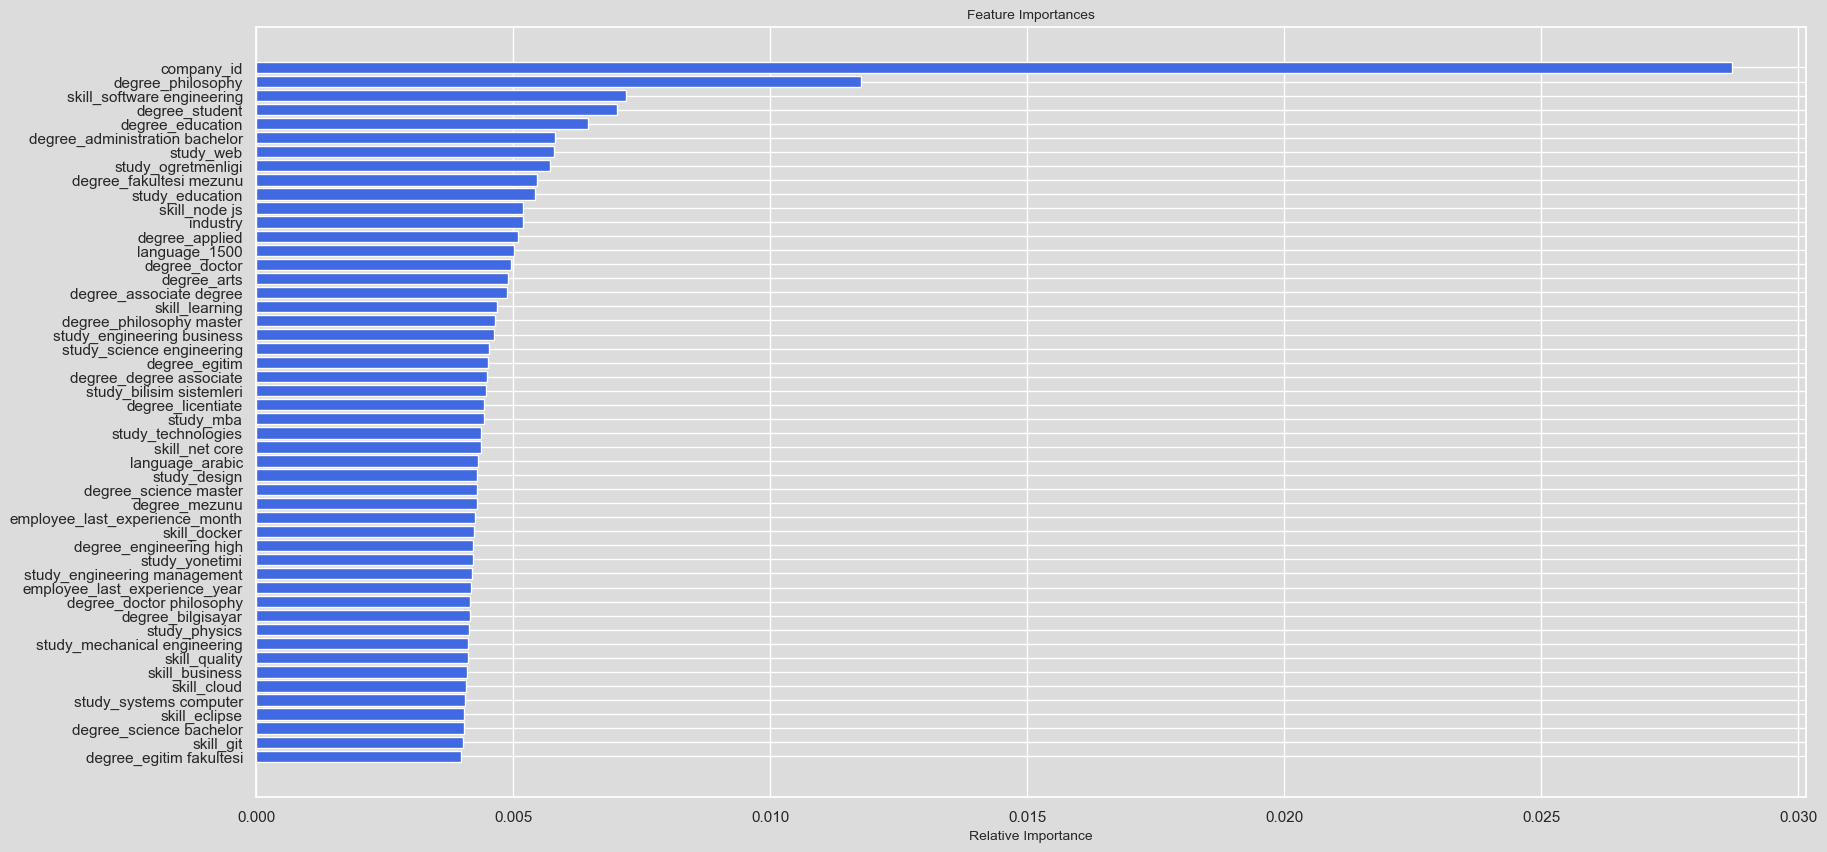

fold accuracy: 0.7821412403802626
-----------------------------------| Fold 6 |-----------------------------------
[0]	validation_0-logloss:0.68972
[200]	validation_0-logloss:0.53235
[400]	validation_0-logloss:0.50131
[600]	validation_0-logloss:0.48154
[800]	validation_0-logloss:0.46701
[1000]	validation_0-logloss:0.45726
[1200]	validation_0-logloss:0.45047
[1400]	validation_0-logloss:0.44604
[1600]	validation_0-logloss:0.44374
[1800]	validation_0-logloss:0.44286
[2000]	validation_0-logloss:0.44293
[2200]	validation_0-logloss:0.44395
[2259]	validation_0-logloss:0.44432


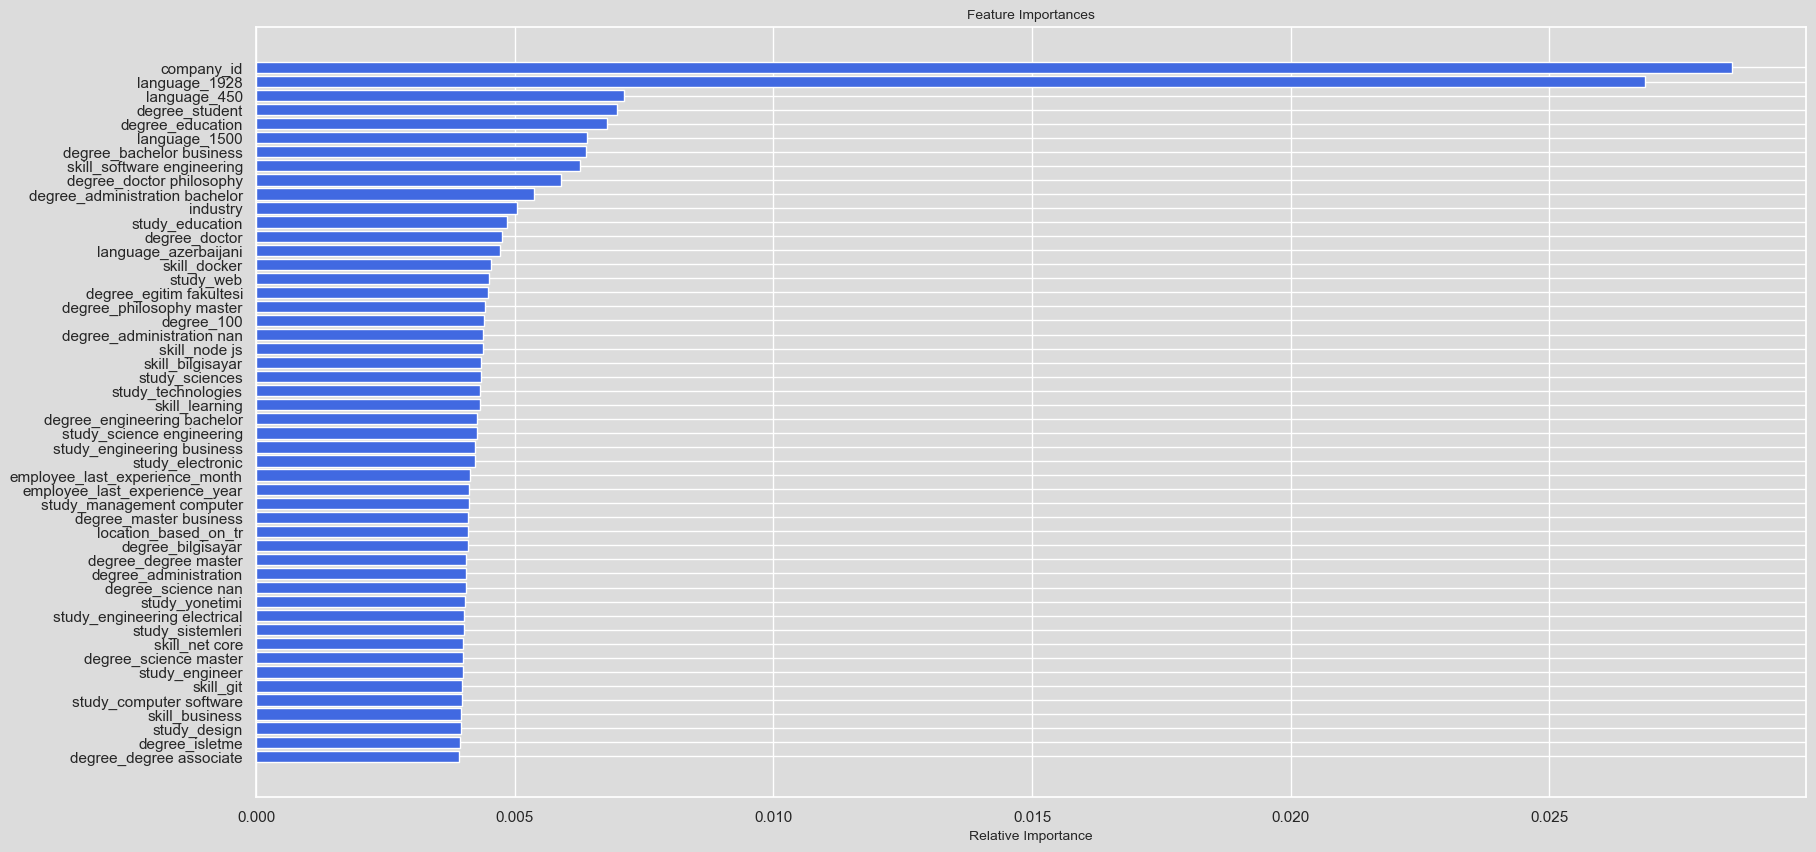

fold accuracy: 0.7875735626980535
accuracy: 0.7855674380882325
folds avg accuracy: 0.7855673765695522


In [10]:
xgb_params = {'max_depth': 12,
              'subsample': 0.8412208136691927,
              #'eta': 0.02,
              #'reg_alpha': 2,
              #'reg_lambda': 24,
              #'max_cat_to_onehot': 160,
              'learning_rate': 0.017307888942046504
              }

#xgb_params['eval_metric'] = 'accuracy'
xgb_params['enable_categorical'] = True
xgb_params['random_state'] = config.seed
xgb_params['tree_method'] = 'hist'
xgb_params['n_estimators'] = 5000

#kf = KFold(n_splits=config.n_folds)
kf = KFold(n_splits=config.n_folds, shuffle =True, random_state=config.seed)

X = train_set.drop(columns=[target], axis=1)
y = train_set[target]
features = X.columns

X_test = test_set.drop(columns=[target], axis=1)
y_oof = np.zeros(X.shape[0])
y_pred = np.zeros(X_test.shape[0])
y_score = np.zeros((X_test.shape[0], 2))

scores = list()
for idx, (train_ind, val_ind) in enumerate(kf.split(X, y)):
    print(f"| Fold {idx+1} |".center(80, "-"))
    model = XGBClassifier(**xgb_params)
    X_train = X.iloc[train_ind]
    y_train = y.iloc[train_ind]
    X_val = X.iloc[val_ind]
    y_val = y.iloc[val_ind]

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds = 400,
        verbose = 200
    )

    plot_importances(model, features)

    val_pred = model.predict(X_val)
    y_oof[val_ind] += val_pred

    test_pred = model.predict(X_test)
    y_pred += test_pred / config.n_folds

    test_score = model.predict_proba(X_test)
    y_score += test_score / config.n_folds

    print(f'fold accuracy: {accuracy_score(y_val, val_pred)}')
    scores.append(accuracy_score(y_val, val_pred))
    del X_train, y_train, X_val, y_val
    gc.collect()

val_score = accuracy_score(y, y_oof)
print(f'accuracy: {val_score}')
print(f'folds avg accuracy: {np.mean(scores)}')
xgb_scores = deepcopy(y_score)

In [38]:
sub[target] = np.where((cat_scores[:, 1] * 0.6) + (xgb_scores[:, 1] * 0.4) >= 0.5, 1, 0)

sub.head()

,user_id,moved_after_2019
0,17449,0
1,33967,1
2,2110,0
3,55082,0
4,37165,0


In [39]:
sub[target].value_counts()

0    9047
1    4208
Name: moved_after_2019, dtype: int64

In [40]:
sub.to_csv(f'../submissions/ensemble_cat_xgb_v8.csv', index = False)